In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install kor2vec

In [ ]:
import torch
import torch.optim as optim
from PIL import Image
import os
import re
from tqdm import tqdm, tqdm_notebook
from torch.utils.data import Dataset
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as T
from torchvision import transforms
import torchvision.datasets as datasets
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from mlxtend.preprocessing import TransactionEncoder
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

import tensorflow as tf
from keras.models import Model
from sklearn.metrics.pairwise import cosine_similarity
from numpy.linalg import norm
import pandas as pd
import numpy as np
import unicodedata
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img,img_to_array
import ast
import re
from numpy.linalg import norm
import math
import time
import cv2
import pickle
from kor2vec import Kor2Vec

### Show and tell
#### 줄거리 + 포스터 이미지 multimodal embedding

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/캡스톤/데이터/연극+뮤지컬 (+포스터).xlsx')
df = df.drop(df.columns[0], axis=1)
df.head(3)

,Title,줄거리,장르,Image_path,Image,image_name
0,연극 〈운빨로맨스〉- 대학로,점에 살고 점에 죽는 점보늬의 호랑이띠 남자와 하룻밤 보내기 프로젝트 목숨이 걸린 ...,"로맨스, 코믹, 공감/힐링",/content/drive/MyDrive/캡스톤/데이터/연극/연극_포스터,연극 〈운빨로맨스〉- 대학로.png,/content/drive/MyDrive/캡스톤/데이터/연극/연극_포스터/연그...
1,(리얼타임 코믹연극) 택시안에서 - 서울,쾌활하고 유쾌한 택시 운전사 민수 그리고 하영과 소희 두 남녀의 운명적인 만남!\n...,"코믹, 로맨스, 공감/힐링",/content/drive/MyDrive/캡스톤/데이터/연극/연극_포스터,(리얼타임 코믹연극) 택시안에서 - 서울.png,/content/drive/MyDrive/캡스톤/데이터/연극/연극_포스터/(리어...
2,(코믹연극) 달동네-부산,"정음의 아버지 경민은 행정착오로 인해 월남전 참전 중 전사자 처리가 되고,........","코믹, 감동, 드라마",/content/drive/MyDrive/캡스톤/데이터/연극/연극_포스터,(코믹연극) 달동네-부산.gif,/content/drive/MyDrive/캡스톤/데이터/연극/연극_포스터/(코미...


In [ ]:
model_dir = "/content/drive/MyDrive/캡스톤/데이터/"
img_dir = '/content/drive/MyDrive/캡스톤/데이터/포스터/'
kor_vec_name= "embedding_final_1"
location = '/content/drive/MyDrive/캡스톤/데이터/'

In [ ]:
# 줄거리 전처리 - 한글 영어 빼고 모두 제외
df['줄거리'] = df['줄거리'].apply(lambda x: re.sub(r'[^가-힣a-zA-Z\s]', '', x))
df['줄거리']

0      점에 살고 점에 죽는 점보늬의 호랑이띠 남자와 하룻밤 보내기 프로젝트 목숨이 걸린 ...
1      쾌활하고 유쾌한 택시 운전사 민수 그리고 하영과 소희 두 남녀의 운명적인 만남\n남...
2      정음의 아버지 경민은 행정착오로 인해 월남전 참전 중 전사자 처리가 되고\n잘못된 ...
3      이중계약으로 엮인 사랑스러운 두 청춘의 동화 같은 사랑이 시작된다 상큼발랄 좌충우돌...
4      가족에게는 그 어떤 힘든 시기도 헤쳐나갈 기적 같은 힘이 있습니다\n엄마의 전화 한...
                             ...                        
122    음악을 하고 싶은 연수 하지만 홀로 연수를 키워온 연수의 아빠 이암은\n무섭고도 절...
123    락 밴드 연습생들 감옥 가다 가수의 꿈을 안고 혹독한 준비를 해왔지만 사기를 당한 ...
124    일년에 치를 제사가 무려 번 오늘도 제사 때문에 등골이 휘는 필례는 남편 봉식을 짐...
125    통통 튀는 매력 존  캣의 풋풋함과\n책  캐서린의 무르익은 감정을 비교하며\n감상...
126    악마들의 가지 유혹의 기술\nI 피곤하게 하고 짜증내게 하라\nII 영혼을 위해 기...
Name: 줄거리, Length: 127, dtype: object

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize(224),
     transforms.CenterCrop(224),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# kor2vec_hyperparameter 조정
embed_size_tune = 64
batch_size_tune = 64
seq_length = 20

In [ ]:
class preprocess(Dataset):

  def max_len(x):
    return len(x)

  def split_(x):
    return x.split(' ')

  def str1(x):
    k=' '.join(x)
    return k

  # review_token 전처리

  df['줄거리']=df['줄거리'].apply(split_)
  df['줄거리']=df['줄거리'].apply(str1)


  if kor_vec_name not in (model_dir):

    # 줄거리 데이터를 사용해 임베딩을 학습 실시

    rev = pd.Series("<sos> " + df['줄거리']+" <end>")
    rev.to_csv(model_dir+"summary_text_corpus.csv")


    kor2vec = Kor2Vec(embed_size=embed_size_tune)
    kor2vec.train(model_dir+"summary_text_corpus.csv", 'model.kor2vec', batch_size=batch_size_tune)
    kor2vec.save(model_dir+ kor_vec_name)

Reading Corpus lines


Corpus Sampling: 100%|██████████| 492/492 [00:00<00:00, 2483.37it/s]


Training kor2vec
Loading Word_sample corpus
Loading corpus finished
CUDA Available/count: False 0
training on  cpu


EP 0: 100%|██████████| 127/127 [00:14<00:00,  8.60it/s]


{'epoch': 0, 'train_ep_loss': 1.8984132770478257}


EP 1: 100%|██████████| 127/127 [00:12<00:00, 10.20it/s]


{'epoch': 1, 'train_ep_loss': 1.3070897305105615}


EP 2: 100%|██████████| 127/127 [00:07<00:00, 17.49it/s]


{'epoch': 2, 'train_ep_loss': 1.197259437850141}


EP 3: 100%|██████████| 127/127 [00:05<00:00, 24.35it/s]


{'epoch': 3, 'train_ep_loss': 1.0990069264502038}


EP 4: 100%|██████████| 127/127 [00:07<00:00, 16.63it/s]


{'epoch': 4, 'train_ep_loss': 1.005397899413672}


EP 5: 100%|██████████| 127/127 [00:05<00:00, 24.09it/s]


{'epoch': 5, 'train_ep_loss': 0.9176024160985872}


EP 6: 100%|██████████| 127/127 [00:05<00:00, 24.19it/s]


{'epoch': 6, 'train_ep_loss': 0.8348009055993688}


EP 7: 100%|██████████| 127/127 [00:07<00:00, 16.55it/s]


{'epoch': 7, 'train_ep_loss': 0.7575835775671982}


EP 8: 100%|██████████| 127/127 [00:05<00:00, 24.48it/s]


{'epoch': 8, 'train_ep_loss': 0.6855161405923799}


EP 9: 100%|██████████| 127/127 [00:05<00:00, 22.17it/s]


{'epoch': 9, 'train_ep_loss': 0.6183098237814866}


In [ ]:
class CaptionDataset(Dataset):

    def __init__(self, img_dir, caption_df, transform=None):
        self.root_dir = img_dir
        self.transform = transform
        self.df = caption_df

        self.imgs = self.df['Image']
        self.captions = self.df["줄거리"]
        self.kor2vec = Kor2Vec.load(model_dir+ kor_vec_name)


    def __len__(self):
        return len(self.df)

    # 이미지, 텍스트를 불러 오는 메소드
    # transform을 선언하면 임베딩 벡터와 1개 배치로 반환하며, 선언하지 않으면 이미지와 스트링 형태의 캡션을 반환
    def __getitem__(self, idx):
        caption = self.captions[idx]      # target caption

        img_name = self.imgs[idx]
        img_location = os.path.join(self.root_dir, img_name)
        img = Image.open(img_location).convert("RGB")

        # transform이 있다면 실시 후 배치화(1 차원 추가)
        if self.transform is not None:
          img = self.transform(img)
          # 정답 임베딩 데이터
          caption = self.kor2vec.embedding(caption, seq_len=seq_length)

        return img, caption

In [ ]:
reveiw_train_data = CaptionDataset(img_dir, df, transform=transform)

img, rev = reveiw_train_data[0]

print(f"img shape : {img.shape}")
print(f"rev : {rev.shape}")
df_train_dataloader = DataLoader(reveiw_train_data, batch_size=batch_size_tune, shuffle=True)

img shape : torch.Size([3, 224, 224])
rev : torch.Size([20, 64])


In [ ]:
embed_size_tune = 64
batch_size_tune = 64
seq_length = 20
drop_out_per = 0.5
learning_rate=0.001
epoch_time=5
kor_vec_name= "embedding_final_1"
kor2Vec_location=model_dir+kor_vec_name

In [ ]:
class Decoder(nn.Module):

    def __init__(self, output_dim, emb_dim, hid_dim, dropout):
        super().__init__()
        self.hid_dim = hid_dim
        self.output_dim = output_dim
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim + hid_dim, hid_dim)
        self.fc_out = nn.Linear(emb_dim + hid_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, context):
        embedded = self.dropout(input)
        emb_con = torch.cat((embedded, context), dim = 2)
        output, hidden = self.rnn(emb_con, hidden)
        output = torch.cat((embedded.squeeze(0), hidden.squeeze(0), context.squeeze(0)),
                           dim = 1)
        prediction = self.fc_out(output)
        return prediction.unsqueeze(0), hidden

In [ ]:
class Net(nn.Module):

  def __init__(self, seq_len = seq_length, embedding_size = embed_size_tune, hidden_size = embed_size_tune):
    super(Net, self).__init__()
    self.seq_len = seq_len
    self.embedding_size = embedding_size
    self.hidden_size = hidden_size
    self.resnet = models.resnet18(pretrained=True)
    self.decoder = Decoder(embed_size_tune, self.embedding_size, self.hidden_size, drop_out_per)
    self.kor2vec = Kor2Vec.load(kor2Vec_location)

    # resNet의 모든 파라미터를 잠그고 마지막 레이어만 얼리지 않고 사용
    for param in self.resnet.parameters():
       param.requires_grad = False
    self.resnet.fc = nn.Linear(512, embed_size_tune) # 마지막 레이어만 다시 사용

    # kor2vec의 모든 파라미터를 얼리기
    for param in self.kor2vec.parameters():
       param.requires_grad = False

  def forward(self, x):
    batch_size = x.shape[0]
    x = self.resnet(x).reshape(1,batch_size,self.hidden_size)
    hidden = x    # lstm의 초기 셀 값은 resNet의 출력
    outputs = torch.zeros(self.seq_len, batch_size, self.embedding_size)  # sequence를 저장하기 위한 빈 배열

    # <sos> 를 시작 토큰으로 설정
    output = self.kor2vec.embedding('<sos>').unsqueeze(0).repeat(1, batch_size, 1)

    # seq 결과물을 lstm의 입력으로 사용하여 seq_len 만큼 반복하여 저장
    for t in range(0, self.seq_len):
        output, hidden = self.decoder(output, hidden, x )
        outputs[t] = output

    return outputs.reshape(batch_size, self.seq_len, self.embedding_size)


  def give_embedding(self, x):
    batch_size = x.shape[0]
    x = self.resnet(x).reshape(1,batch_size,self.hidden_size)
    hidden = x # lstm의 초기 셀 값은 resNet의 출력
    outputs = torch.zeros(self.seq_len, batch_size, self.embedding_size) # sequence를 저장하기 위한 빈 배열

    # <sos> 를 시작 토큰으로 설정
    output = self.kor2vec.embedding('<sos>').unsqueeze(0).repeat(1, batch_size, 1)

    # seq 결과물을 lstm의 입력으로 사용하여 seq_len = 15 만큼 반복하여 저장
    output, hidden = self.decoder(output, hidden, x )
    return hidden

  def give_resnet_embedding(self, x):
    batch_size = x.shape[0]
    x = self.resnet(x).reshape(1,batch_size,self.hidden_size) # resnet 통과 output: (batch, hidden)

    hidden =x # lstm의 초기 셀 값은 resNet의 출력
    return hidden

  # model.train()
  def train(self, mode=True):
    self.training = mode
    for module in self.children():
      if module != self.kor2vec:
        module.train(mode)
    return self

  # model.eval()
  def eval(self, mode=False):
    # self.training = mode
    for module in self.children():
      if module != self.kor2vec:
        module.train(mode)
    return self

In [ ]:
show_and_tell_model = Net()
criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(show_and_tell_model.parameters(), lr=learning_rate)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 98.8MB/s]


In [ ]:
model_name="show_and_tell_final.pt"
py_dir = "show_and_tellfile/"

In [ ]:
if model_name not in (model_dir+py_dir):

  # 신경망 학습
  for epoch in range(epoch_time):
    running_loss = 0.0

    for i, data in enumerate(df_train_dataloader):
      img, label = data[0].squeeze(1), data[1]
      optimizer.zero_grad()
      output = show_and_tell_model(img)

      loss = criterion(output.squeeze(1), label)
      loss.backward()
      optimizer.step()

      running_loss += loss.item()

      if i>= len(reveiw_train_data) - 1: break

      if (i % 10) == 0:
              print('[%d, %5d] loss: %.3f' %
                    (epoch +1, i+1, running_loss / (i + 1)))
              running_loss =0.0

  torch.save(show_and_tell_model.state_dict(), model_dir+py_dir+model_name)

[1,     1] loss: 0.235
[2,     1] loss: 0.210
[3,     1] loss: 0.199
[4,     1] loss: 0.202
[5,     1] loss: 0.196


In [ ]:
embedding_dir="review_embeddings_test.pickle"
show_and_tell_model.load_state_dict(torch.load(model_dir+py_dir+model_name))

In [ ]:
# 가장 유사한, 가장 유사하지 않은 것 비교 코드

if embedding_dir not in (model_dir+py_dir):
  i_list = []
  embed_list = []

  # 모든 이미지에 대한 임베딩 계산
  for i, data in enumerate(reveiw_train_data):
      show_and_tell_model.eval()

      img, label = data[0], data[1]
      img = img.unsqueeze(0)
      embed = show_and_tell_model.give_embedding(img).cpu().detach().numpy()

      i_list.append(i)
      embed_list.append(embed)

      if i>= len(reveiw_train_data) - 1: break

      if i%100 == 0:
        print(f"image done : {i}")

  with open(model_dir+py_dir+embedding_dir, 'wb') as f:
      pickle.dump(embed_list, f, pickle.HIGHEST_PROTOCOL)

else:
  with open(model_dir+py_dir+embedding_dir, 'rb') as f:
      embed_list = pickle.load(f)

image done : 0
image done : 100


In [ ]:
def load_pickle(filename):
    with open(filename, 'rb') as f:
        res = pickle.load(f)
    return res
def save_pickle(data, filename):
    with open(filename, 'wb') as f:
        pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
embed_list = load_pickle('/content/drive/MyDrive/캡스톤/데이터/show_and_tellfile/review_embeddings_test.pickle')
embed_list

## 장르 embedding

In [ ]:
gen_vecs = load_pickle('/content/drive/MyDrive/캡스톤/데이터/genres_vecs.pickle')
gen_vecs

array([[-0.1811912 ,  0.52933705, -0.2526065 , ...,  0.42428982,
        -0.34360644,  0.14504915],
       [-0.1811912 ,  0.52933705, -0.2526065 , ...,  0.42428982,
        -0.34360644,  0.14504915],
       [-0.16639581, -0.10462555,  0.28942317, ..., -0.2565856 ,
        -0.603117  , -0.07809109],
       ...,
       [-0.15018377, -0.24559212,  0.3026621 , ..., -0.3633618 ,
        -0.11072537, -0.14213105],
       [-0.2177245 ,  0.4107043 , -0.11678484, ...,  0.4757371 ,
        -0.31094345,  0.01781753],
       [ 0.08477031, -0.18339545, -0.1202151 , ...,  0.2526248 ,
        -0.23496172, -0.06008792]], dtype=float32)

## 사용자 데모 embedding

In [ ]:
demo_vecs = load_pickle('/content/drive/MyDrive/캡스톤/데이터/demo_vecs.pickle')
demo_vecs

,male,female,age_10대,age_20대,age_30대,age_40대,age_50대
0,0.380,0.620,1,0,0,0,0
1,0.437,0.563,0,1,0,0,0
2,0.432,0.568,0,0,0,1,0
3,0.403,0.597,0,1,0,0,0
4,0.169,0.831,0,0,1,0,0
...,...,...,...,...,...,...,...
122,0.397,0.603,1,0,0,0,0
123,0.287,0.713,1,0,0,0,0
124,0.283,0.717,0,0,1,0,0
125,0.333,0.667,0,1,0,0,0


## 추천 시스템 구현

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/캡스톤/데이터/연극+뮤지컬 (+포스터).xlsx')
df = df.drop(df.columns[0], axis=1)
df['Image'] = [unicodedata.normalize('NFC', filename) for filename in df['Image']]
df.head(3)

,Title,줄거리,장르,Image_path,Image,image_name
0,연극 〈운빨로맨스〉- 대학로,점에 살고 점에 죽는 점보늬의 호랑이띠 남자와 하룻밤 보내기 프로젝트 목숨이 걸린 ...,"로맨스, 코믹, 공감/힐링",/content/drive/MyDrive/캡스톤/데이터/연극/연극_포스터,연극 〈운빨로맨스〉- 대학로.png,/content/drive/MyDrive/캡스톤/데이터/연극/연극_포스터/연그...
1,(리얼타임 코믹연극) 택시안에서 - 서울,쾌활하고 유쾌한 택시 운전사 민수 그리고 하영과 소희 두 남녀의 운명적인 만남!\n...,"코믹, 로맨스, 공감/힐링",/content/drive/MyDrive/캡스톤/데이터/연극/연극_포스터,(리얼타임 코믹연극) 택시안에서 - 서울.png,/content/drive/MyDrive/캡스톤/데이터/연극/연극_포스터/(리어...
2,(코믹연극) 달동네-부산,"정음의 아버지 경민은 행정착오로 인해 월남전 참전 중 전사자 처리가 되고,........","코믹, 감동, 드라마",/content/drive/MyDrive/캡스톤/데이터/연극/연극_포스터,(코믹연극) 달동네-부산.gif,/content/drive/MyDrive/캡스톤/데이터/연극/연극_포스터/(코미...


In [ ]:
# 이미지 줄거리 벡터 + 장르 벡터 + 사용자 데모 벡터 concat

x1 = pd.concat([review_numpy, gen_numpy], axis=1)
x2 = pd.concat([x1, demo_vecs], axis=1)
x2

,0,1,2,3,4,5,6,7,8,9,...,125,126,127,male,female,age_10대,age_20대,age_30대,age_40대,age_50대
0,0.340092,0.270717,-0.685962,-0.358355,-0.358701,-0.135686,-0.221630,0.652409,-0.862135,0.259537,...,0.424290,-0.343606,0.145049,0.380,0.620,1,0,0,0,0
1,-0.111247,0.107101,-0.069891,-0.198495,-0.088026,-0.556505,0.011032,0.544252,-0.246347,-0.044874,...,0.424290,-0.343606,0.145049,0.437,0.563,0,1,0,0,0
2,0.173725,0.172131,-0.354059,-0.719077,-0.522786,0.291030,-0.158629,0.671764,-0.591013,0.429994,...,-0.256586,-0.603117,-0.078091,0.432,0.568,0,0,0,1,0
3,0.496162,0.327106,-0.258069,-0.472944,-0.029297,0.214609,-0.125792,0.631572,-0.453194,0.309827,...,0.729516,-0.448372,0.000607,0.403,0.597,0,1,0,0,0
4,0.124473,0.158157,-0.389772,-0.712820,-0.569859,-0.179123,-0.203513,0.309932,0.035641,0.361835,...,-0.155501,-0.525974,-0.163065,0.169,0.831,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,0.199338,0.497198,-0.329468,-0.464751,-0.405617,-0.249212,-0.214595,0.669629,-0.717588,0.259729,...,-0.363362,-0.110725,-0.142131,0.397,0.603,1,0,0,0,0
123,0.009642,0.444250,-0.397509,-0.527245,-0.399151,-0.165296,-0.116262,0.495110,-0.587577,0.214668,...,-0.143883,-0.129140,-0.012285,0.287,0.713,1,0,0,0,0
124,0.359228,-0.013707,-0.199465,-0.442704,-0.446824,0.348578,-0.059406,-0.026986,-0.262175,-0.030484,...,-0.363362,-0.110725,-0.142131,0.283,0.717,0,0,1,0,0
125,-0.198141,0.292369,0.216813,-0.546124,0.000306,-0.052388,-0.108666,0.945923,-0.908515,0.187340,...,0.475737,-0.310943,0.017818,0.333,0.667,0,1,0,0,0


In [ ]:
def image_plus_2(df, img_dir, title_name):

  # input_title과 일치하는 작품의 인덱스 추출
  if df["Title"].isin([title_name]).any():

    target_idx=df[df["Title"]==title_name].index.to_list()[0]

    with open(location+'review_embeddings_test.pickle', 'rb') as f:
        review_vecs = pickle.load(f)
    with open(location+'genres_vecs.pickle', 'rb') as f:
        gen_vecs = pickle.load(f)
    with open(location+'demo_vecs.pickle', 'rb') as f:
        demo_vecs = pickle.load(f)

    review_numpy = np.squeeze(np.array(review_vecs))
    review_numpy = pd.DataFrame(review_numpy)
    gen_numpy=np.squeeze(np.array(gen_vecs))
    gen_numpy= pd.DataFrame(gen_numpy)

    x1 = pd.concat([review_numpy, gen_numpy], axis=1)
    x2 = pd.concat([x1, demo_vecs], axis=1)
    x2

    # 유클리드 유사도를 통한 유사도 계산
    dist_mtx = euclidean_distances(x2, x2)

    title_name = df['Image'].iloc[target_idx]
    plt.imshow(Image.open(img_dir + title_name))
    plt.show()

    # target과 가장 가까운 작품 10개
    close_list = dist_mtx[target_idx].argsort()[1:11]

    print("가장 가까운 이미지")
    print("======================")
    for i, idx in enumerate(close_list):
        img, tit = df['Image'].iloc[idx], df['Title'].iloc[idx]
        print(f"{i}, {tit}, distance : {dist_mtx[target_idx][idx]}")
        plt.imshow(Image.open(img_dir + img))
        plt.show()

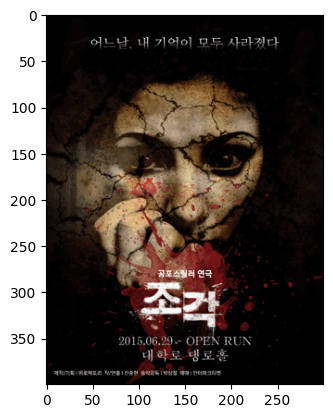

가장 가까운 이미지
0, 4D공포연극 〈스위치〉, distance : 3.364874254091424


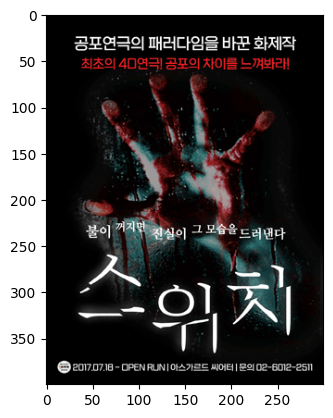

1, 공포연극 ［자취］, distance : 3.5839973021045335


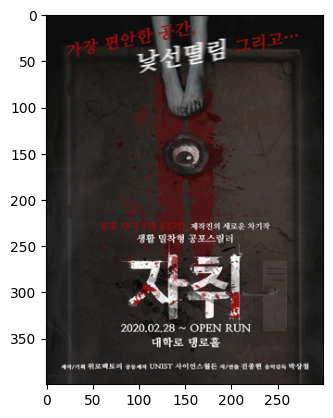

2, 공포스릴러연극〈두여자〉- 대구, distance : 3.75240378413512


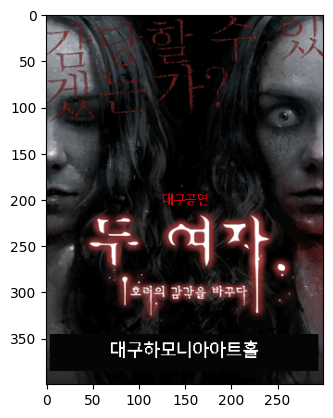

3, 국민 코믹 연극 〈오백에삼십〉 - 대학로 세우아트센터 1관, distance : 3.954783239408992


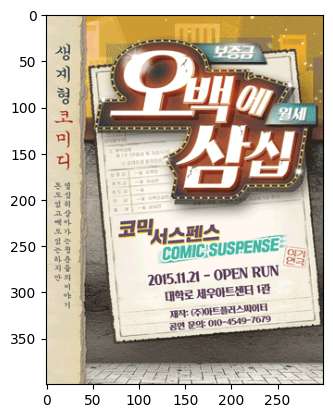

4, ［연극 on stage］ 99% - 화성, distance : 4.197778316857274


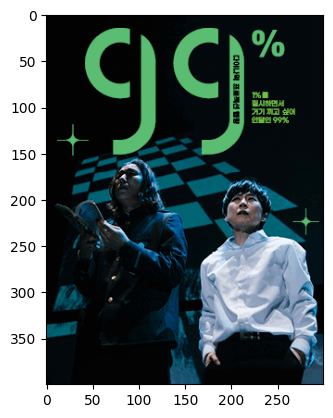

5, 뮤지컬 〈레베카〉 10주년 기념공연, distance : 4.41414526861755


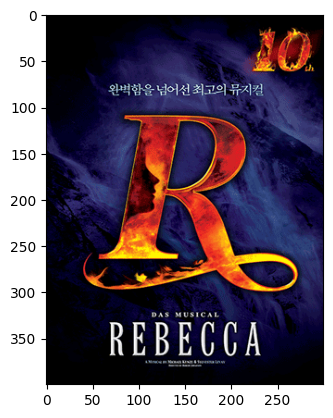

6, 대학로 1위 연극 〈쉬어매드니스〉, distance : 4.483974656078448


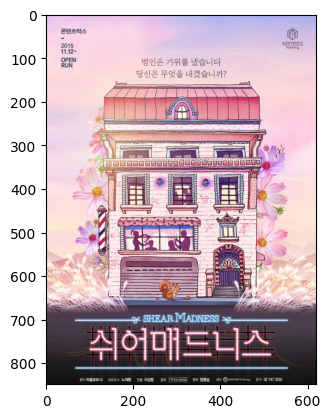

7, 러스트(RUST) - 전주, distance : 4.552244993657767


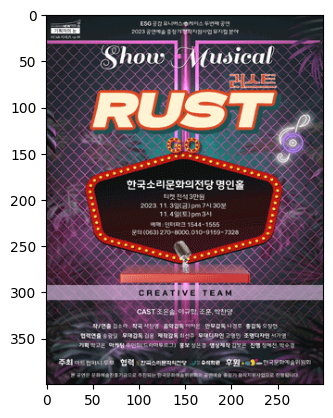

8, 괴물B, distance : 4.593764735692469


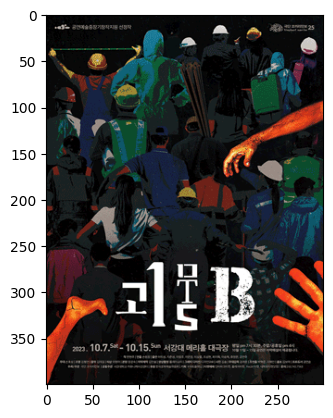

9, 행오버, distance : 4.643255631681894


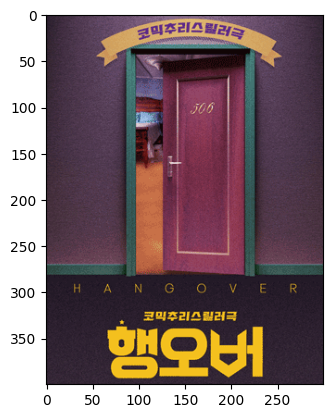

In [ ]:
image_plus_2(df, img_dir, '공포연극 조각')